In [294]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.insert(1,'../analysis/')
sys.path.insert(1,'../optimization/')
from results_plotting import *
import plant_optimization as pop

In [296]:
results_paths = '../../results/plant_optimization/final_results'

# Import grid
europe_grid, europe_borders = load_base_maps()
europe_grid = europe_grid[['lat','lon','country','sea_node','geometry']]
merge_cols = list(europe_grid.columns)
merge_cols.remove('geometry')

# Import 2020 results
year = '2020'
data_2020 = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))
data_2020_geo = gpd.GeoDataFrame(data_2020.drop(columns=['geometry'])).merge(europe_grid,on=merge_cols,how='left')
countries = data_2020.country.unique()

# PV resources

In [297]:
filenames = os.listdir('../../results/PV_power_output/')

geo_joiner = data_2020_geo[['lat','lon','country','shore_designation','geometry']].copy()
PV_geo = []
for filename in filenames:
    pv_data = pd.read_parquet(os.path.join('../../results/PV_power_output',filename))
    pv_data = pv_data[['Wh']].groupby(['lat','lon']).sum()
    pv_data['kWh_per_kW'] = pv_data['Wh']/1e3
    pv_data['country'] = filename.replace('_PV.parquet.gzip','')
    pv_data['shore_designation'] = 'onshore'
    pv_data = pv_data.reset_index(drop=False)
    
    PV_geo.append(pd.merge(geo_joiner, pv_data[['lat','lon','country','shore_designation','kWh_per_kW']], on=['lat','lon','country','shore_designation']))
#     break
PV_geo_df = pd.concat(PV_geo)

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/fastparquet/core.py:278: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


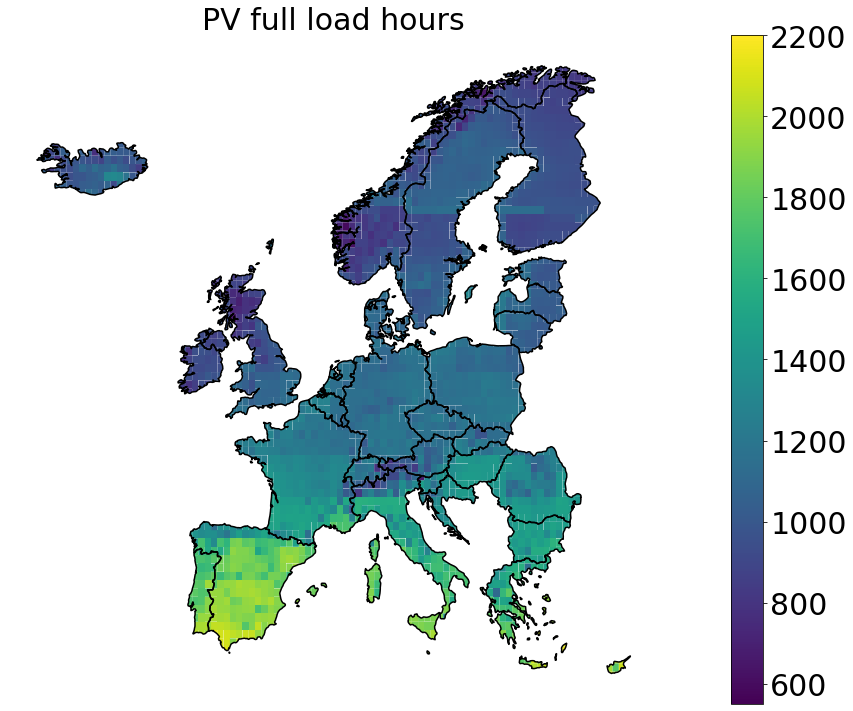

In [5]:
metrics = {'kWh_per_kW':'PV full load hours'}
vmax_dict = {'kWh_per_kW':2200}
vmin_dict = {'kWh_per_kW':550}
legend_kwds = {'orientation':'vertical'}
missing_kwds = {'color':'lightgrey'}
fontsize = 30
plot_results(data=PV_geo_df,countries=countries,metrics=metrics,vmax_dict=vmax_dict,vmin_dict=vmin_dict,missing_kwds=missing_kwds,legend_kwds=legend_kwds,cmap='viridis',figsize=(20,10),fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.08)
plt.savefig('../../gfx/PV_potential.png',dpi=400, bbox_inches='tight')

# Installed capacities

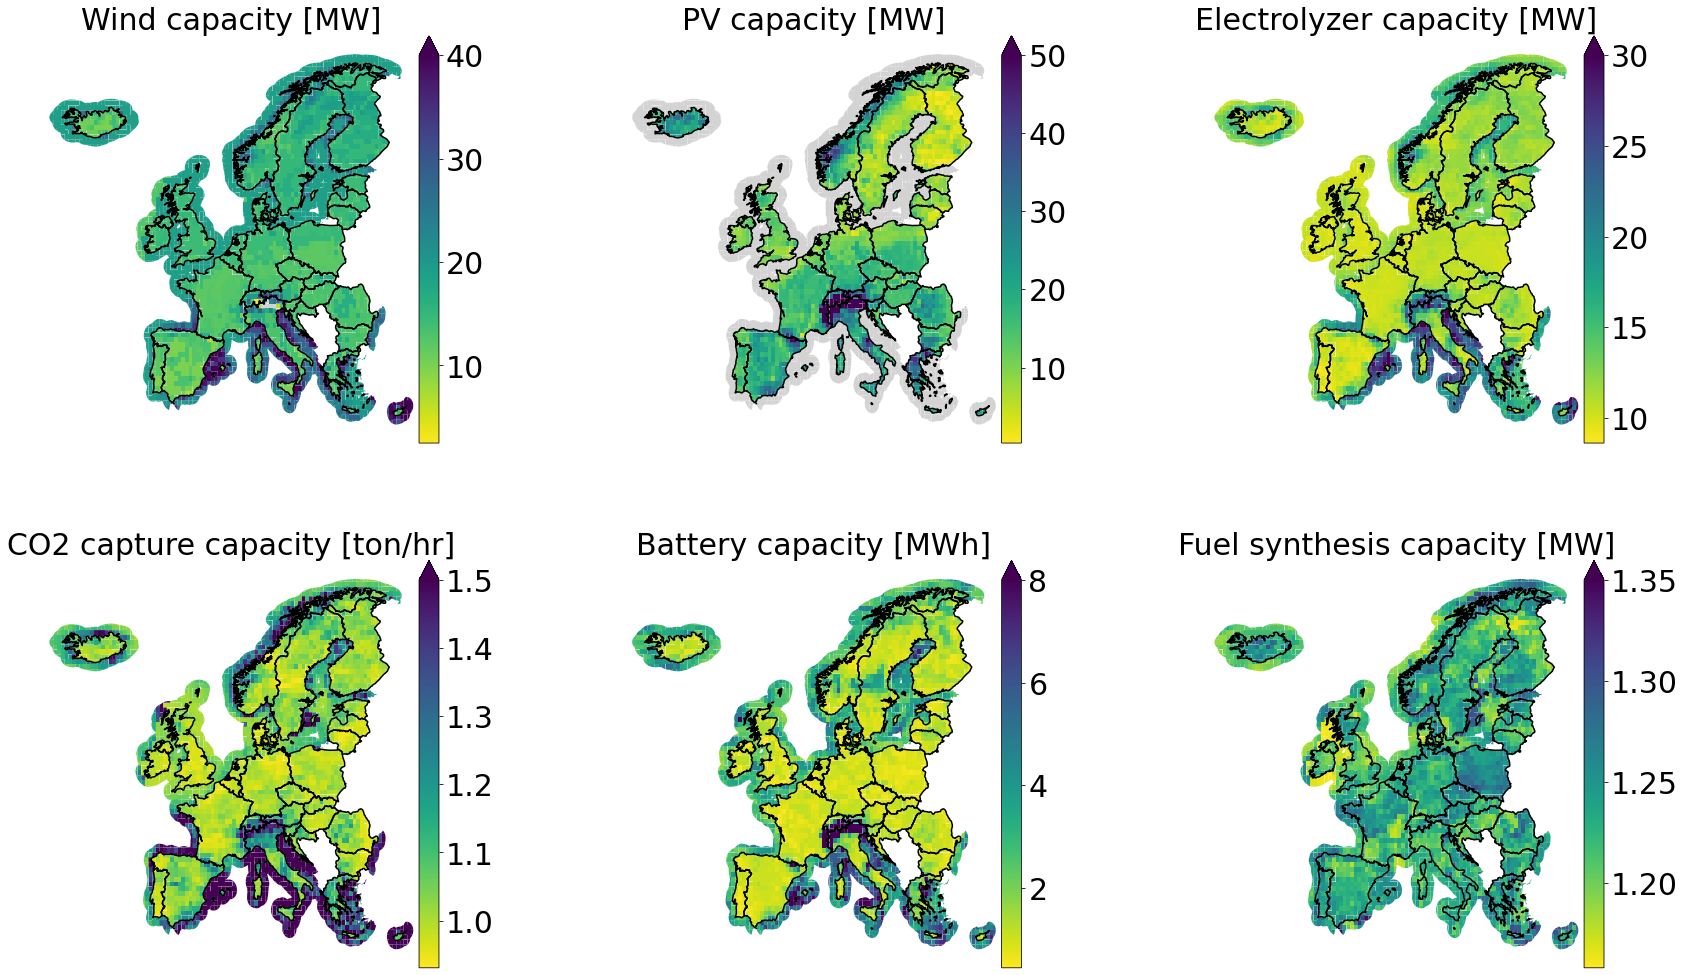

In [6]:
data = data_2020_geo.copy()
data.loc[data.battery_capacity_MWh==0,'battery_capacity_MWh'] = np.nan
data.loc[data.PV_capacity_MW==0,'PV_capacity_MW'] = np.nan
data.loc[data.wind_capacity_MW==0,'wind_capacity_MW'] = np.nan
metrics = {'wind_capacity_MW':'Wind capacity [MW]',
           'PV_capacity_MW':'PV capacity [MW]',
           'electrolyzer_capacity_MW':'Electrolyzer capacity [MW]',
           'CO2_capture_tonph':'CO2 capture capacity [ton/hr]',
           'battery_capacity_MWh':'Battery capacity [MWh]',
           'H2tL_capacity_MW':'Fuel synthesis capacity [MW]'}
vmax_dict = {'wind_capacity_MW':40,#35,
             'PV_capacity_MW':50,#35,
             'electrolyzer_capacity_MW':30,#35,
             'CO2_capture_tonph':1.5,#3,
             'battery_capacity_MWh':8,#5,
             'H2tL_capacity_MW':1.35}#1.45}
legend_kwds = {'extend':'max','orientation':'vertical'}
missing_kwds = {'color':'lightgrey'}
fontsize = 30
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,missing_kwds=missing_kwds,legend_kwds=legend_kwds,cmap='viridis_r',figsize=(25,15),fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.08)
plt.savefig('../../gfx/component_capacities.png',dpi=400)

# PV vs wind capacities

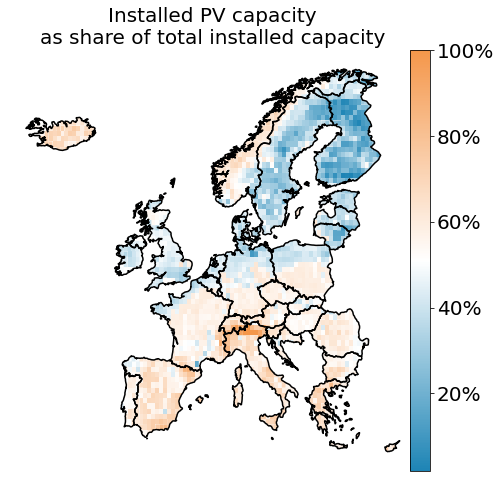

In [7]:
data = data_2020_geo.copy()
data = data.loc[data.shore_designation=='onshore']
data = data[['wind_capacity_MW','PV_capacity_MW','country','geometry','LCOF_liter']]
data['pv_share'] = data['PV_capacity_MW']/ (data['PV_capacity_MW'] + data['wind_capacity_MW'])


metrics = {'pv_share':'Installed PV capacity\nas share of total installed capacity'}

legend_kwds = {'orientation':'vertical'}

cmap = LinearSegmentedColormap.from_list('test',['#1D84B5','white','#F4974B'])

fontsize = 20

fig, axes, cb_ax = plot_results(data=data,countries=countries,metrics=metrics,legend_kwds=legend_kwds,cmap=cmap,figsize=(10,10),fontsize=fontsize)

ticks = cb_ax.get_yticks()
cb_ax.yaxis.set_ticks(ticks)
cb_ax.set_yticklabels([f'{x*100:.0f}%' for x in ticks]);

plt.savefig('../../gfx/pv_share_map.png', bbox_inches='tight', dpi=400)

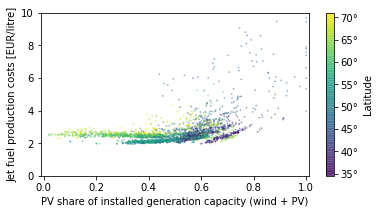

In [8]:
data = data_2020_geo.copy()
data = data.loc[data.shore_designation=='onshore']
data = data[['lat','lon','wind_capacity_MW','PV_capacity_MW','country','geometry','LCOF_liter']]
data['pv_share'] = data['PV_capacity_MW']/ (data['PV_capacity_MW'] + data['wind_capacity_MW'])

cmap = LinearSegmentedColormap.from_list('test',['#1D84B5','white','#F4974B'])


fig,ax = plt.subplots(figsize=(6,3))
sc = ax.scatter(data['pv_share'], data['LCOF_liter'], s=3, alpha=0.5, linewidth=0, c=data['lat'])#, cmap=cmap)
ax.set_ylim(0,10)
ax.set_xlim(-0.01,1.01)
ax.set_ylabel('Jet fuel production costs [EUR/litre]')
ax.set_xlabel('PV share of installed generation capacity (wind + PV)')

cb = plt.colorbar(sc)
cb.set_ticks(cb.get_ticks())
cb.set_ticklabels([f'{x:.0f}'+u'\N{DEGREE SIGN}' for x in cb.get_ticks()])
cb.set_label('Latitude')

plt.savefig('../../gfx/pv_share_lcof_scatter.png', bbox_inches='tight', dpi=400)

# Curtailment

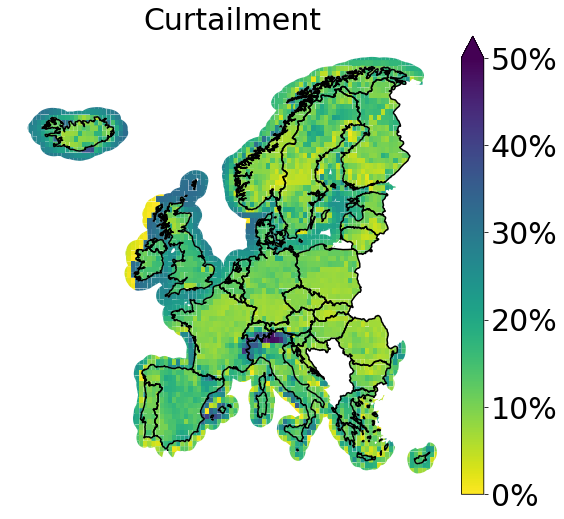

In [9]:
curtailment_data = data_2020_geo[['lat','lon','country','geometry','wind_production_MWh','PV_production_MWh','curtailed_el_MWh']].copy()
curtailment_data['curtailment_ratio'] = curtailment_data['curtailed_el_MWh'] / (curtailment_data['wind_production_MWh'] + curtailment_data['PV_production_MWh']) * 100
metrics = {'curtailment_ratio':'Curtailment'}
vmax_dict = {'curtailment_ratio':50}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 30
fig, axes, cb_ax = plot_results(data=curtailment_data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(10,10),cmap='viridis_r',fontsize=fontsize)
cb_ax.yaxis.set_ticks(cb_ax.get_yticks()) # This line is only intended to supress a warning resulting from the following
cb_ax.set_yticklabels([f'{x:.0f}%' for x in cb_ax.get_yticks()])
plt.tight_layout()
plt.savefig('../../gfx/curtailment.png',dpi=400)

# Turbine types

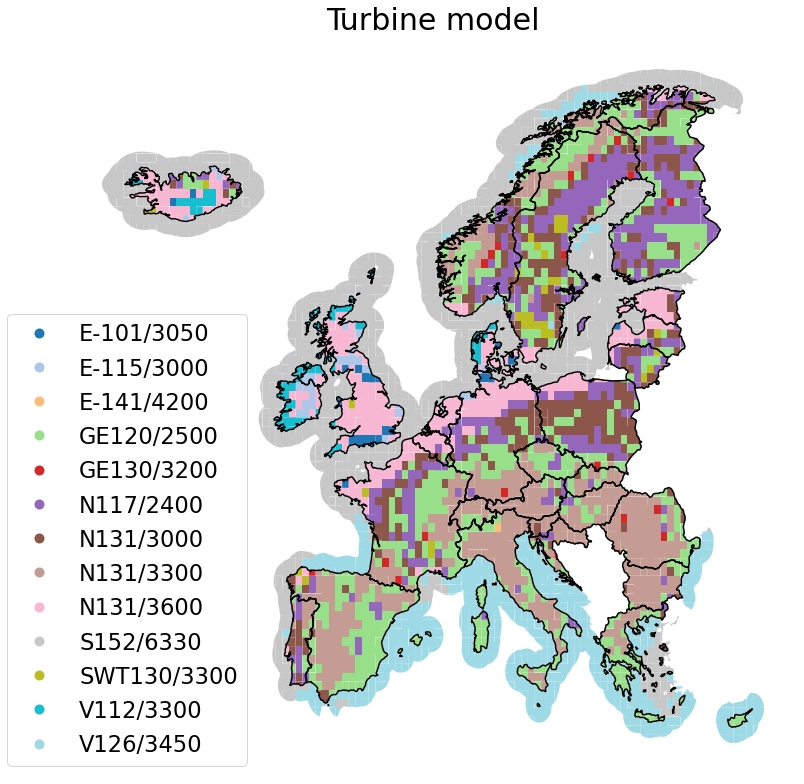

In [10]:
data = data_2020_geo.copy()
metrics = {'turbine_type':'Turbine model'}
vmax_dict = None
legend_kwds = {'loc':'lower left', 'bbox_to_anchor':(-0.1,0), 'ncol':1}
fontsize = 30
plot_results(data=data,countries=countries,metrics=metrics,legend_kwds=legend_kwds,figsize=(11,11),fontsize=fontsize)
plt.tight_layout()
plt.savefig('../../gfx/turbine_models.png',dpi=400)

# Costs

In [298]:
costs_dict = {}
for year in [2020,2030,2040,2050]:
    costs_df = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))

    specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
    specs_names = specs.index

    specs_temp = specs.copy()
    specs_temp['value'] = specs_temp[f'value_{year}']
    # If any specs are not specified for the given year, take the 2020 value
    specs_temp.loc[specs_temp.value.isna(),'value'] = specs_temp.loc[specs_temp.value.isna(),'value_2020']

    components = {'wind':['wind_capacity_MW',1e3],
                  'PV':['PV_capacity_MW',1e3],
                  'battery':['battery_capacity_MWh',1e3],
                  'electrolyzer':['electrolyzer_capacity_MW',1e3],
                  'CO2':['CO2_capture_tonph',8760],
                  'H2stor':['H2stor_capacity_MWh',1e3],
                  'CO2stor':['CO2stor_capacity_ton',1],
                  'H2tL':['H2tL_capacity_MW',1e3],
                  'heat':['boiler_capacity_MW',1e3]}
    discount_rate = specs_temp.at['discount_rate',f'value']
    plant_lifetime = specs_temp.at['lifetime',f'value']

    for component in components.keys():
        costs_df[component+'_NPV'] = np.nan
        costs_df[f'{component}_verify_CAPEX'] = np.nan
    costs_df['verify_NPV'] = np.nan

    for idx,row in costs_df.iterrows():
        verify_NPV = 0
        verify_CAPEX = 0
        for component,value in components.items():
            if component == 'wind':
                if row['shore_designation'] == 'onshore':
                    wind_class = row['wind_class']
                    capex = specs_temp.at[f'{component}_{wind_class}_CAPEX',f'value']
                    opex = specs_temp.at[f'{component}_{wind_class}_OPEX',f'value']
                elif row['shore_designation'] == 'offshore':
                    platform_type = 'monopole' if row['shore_dist']<=60 else 'floating'
                    capex = specs_temp.at[f'{component}_{platform_type}_CAPEX',f'value']
                    opex = specs_temp.at[f'{component}_{platform_type}_OPEX',f'value']
            else:
                capex = specs_temp.at[f'{component}_CAPEX',f'value']
                opex = specs_temp.at[f'{component}_OPEX',f'value']
            component_lifetime = specs_temp.at[f'{component}_lifetime',f'value']
            capacity = row[value[0]]*value[1]
            component_capex = capex * capacity
            costs_df.loc[idx,f'{component}_verify_CAPEX'] = component_capex        
            verify_CAPEX += component_capex

            if component == 'electrolyzer':
                component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=specs_temp.at['electrolyzer_stack_lifetime',f'value'],
                                              capacity=capacity,replacement_capex_fraction=specs_temp.at['electrolyzer_stack_CAPEX',f'value'])                
            else:
                component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=component_lifetime,capacity=capacity,)
            costs_df.loc[idx,component+'_NPV'] = component_npv
            verify_NPV += component_npv
        costs_df.loc[idx,'verify_NPV'] = verify_NPV
        costs_df.loc[idx,'verify_CAPEX'] = verify_CAPEX
    #     if idx == 0:
    #         break
    costs_dict[year] = costs_df

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


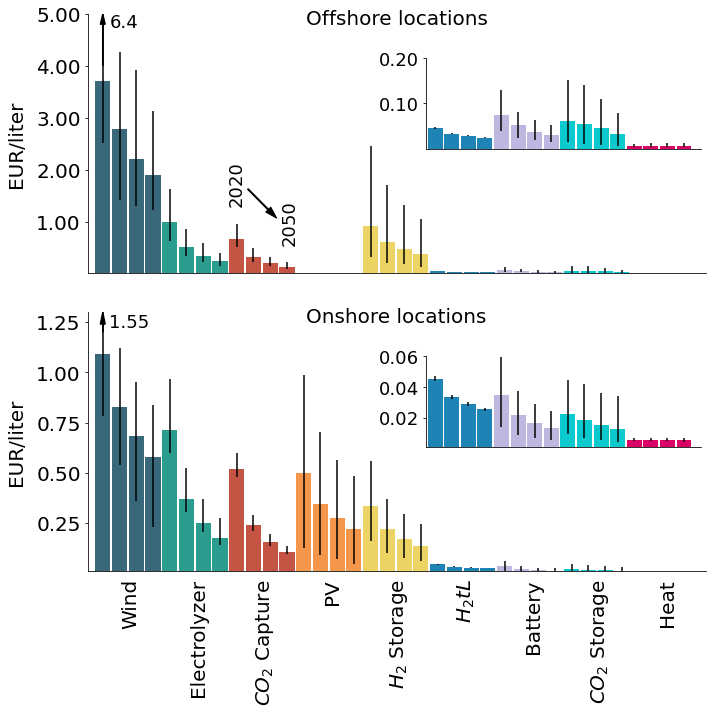

In [435]:
npv_cols = ['wind_NPV', 'electrolyzer_NPV', 'CO2_NPV', 'PV_NPV', 'H2stor_NPV', 'H2tL_NPV', 'battery_NPV', 'CO2stor_NPV', 'heat_NPV']
colors = ['#264653','#2A9D8F','#C45544','#F4974B','#EDD363','#1D84B5','#BEB7DF','#0BC9CD','#D90368','#A4A0A9']
colors = ['#38687a','#2A9D8F','#C45544','#F4974B','#EDD363','#1D84B5','#BEB7DF','#0BC9CD','#D90368','#A4A0A9'] # Slightly lighter shade in the first color
colormap = {x:colors[i] for i,x in enumerate(onshore_npv_cols)}

col_name_map = {
    'wind_NPV':'Wind', 
    'electrolyzer_NPV':'Electrolyzer',
    'CO2_NPV':'$CO_{2}$ Capture',
    'PV_NPV':'PV',
    'H2stor_NPV':'$H_{2}$ Storage',
    'H2tL_NPV':'$H_{2}tL$',
    'battery_NPV':'Battery',
    'CO2stor_NPV':'$CO_{2}$ Storage',
    'heat_NPV':'Heat',
    'verify_NPV':'Total'
}

figsize=(10,10)
fontsize = figsize[0]*2
fig,axes = plt.subplots(nrows=2, figsize=figsize)
width = 0.225
offset = 0.025

for i,shore_designation in enumerate(['offshore','onshore']):
    
    axins = inset_axes(axes[i], width='100%', height='100%', bbox_to_anchor=[5/9, 0.5, 4/9, 0.35], bbox_transform=axes[i].transAxes)
        
    for j,(year,costs_df) in enumerate(costs_dict.items()):
        costs_slice = costs_df.loc[costs_df['shore_designation']==shore_designation,npv_cols]
        costs_slice = levelize_npv(costs_slice)
        costs_slice = costs_slice.describe(percentiles=[0.05,0.5,0.95]).T #* 100

        yerr1 = costs_slice['mean'] - costs_slice['5%']
        yerr2 = costs_slice['95%'] - costs_slice['mean']
        axes[i].bar(np.arange(len(npv_cols))+(width+offset)*j, costs_slice['mean'], width=width, yerr=[yerr1,yerr2], color=costs_slice.index.map(colormap))
        axins.bar(np.arange(4)+(width+offset)*j, costs_slice['mean'].loc['H2tL_NPV':], width=width, yerr=[yerr1.loc['H2tL_NPV':],yerr2.loc['H2tL_NPV':]], color=costs_slice.index.map(colormap)[5:])
    
        if j==0 and i==0:
            axes[i].arrow(0, 4, 0, 0.8, head_width=0.075, head_length=0.2, linewidth=1.25, fc='k', ec='k')
            axes[i].text(0.1, 4.75, round(costs_slice['mean']['wind_NPV']+yerr2['wind_NPV'],2), fontsize=fontsize*0.9)
        elif j==0 and i==1:
            axes[i].arrow(0, 1.2, 0, 0.04, head_width=0.075, head_length=0.06, linewidth=1.25, fc='k', ec='k')
            axes[i].text(0.1, 1.25, round(costs_slice['mean']['wind_NPV']+yerr2['wind_NPV'],2), verticalalignment='center', fontsize=fontsize*0.9)

    
    axins.tick_params(labelsize=fontsize*0.9)
    axins.set_xticks([])
    axins.spines['right'].set_visible(False)
    axins.spines['top'].set_visible(False)
    axins.set_xlim(0-width/2-offset,4)
    
    axes[i].set_xticks(np.arange(len(npv_cols)) + 2*width - offset)
    if i==0:
        axins.set_ylim(0.001,0.2)
        axins.yaxis.set_major_formatter(lambda x, pos: f'{round(x,2):.2f}')
        axes[i].set_xticklabels([])
        axes[i].yaxis.set_major_formatter(lambda x, pos: f'{round(x,2):.2f}')
        axes[i].annotate('', xy=(2+width*3-offset,1), xytext=(2+width/2,1.7), ha='left', va='baseline', fontsize=fontsize*0.9, rotation=90, arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=7))
        axes[i].text(2, 1.75, '2020', ha='center', va='center', fontsize=fontsize*0.9, rotation=90, )
        axes[i].text(2+width*3-offset, 1, '2050', ha='left', va='center', fontsize=fontsize*0.9, rotation=90, )
        
    else:
        axins.set_ylim(0.001,0.06)
        axins.set_yticks([0.02,0.04,0.06])
        axes[i].set_xticklabels(labels=[col_name_map[x] for x in npv_cols])
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)

    axes[i].tick_params(labelsize=fontsize, bottom=False)
    axes[i].set_ylim(0.01,[5,1.3][i])
    axes[i].set_xlim(0-width,len(npv_cols))
    axes[i].set_ylabel('EUR/liter', fontsize=fontsize, labelpad=10)
    
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

    
axes[0].set_title('Offshore locations', pad=-10, fontsize=fontsize)
axes[1].set_title('Onshore locations', pad=-10, fontsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace=0.15,wspace=0.1)
# plt.savefig('../../gfx/cost_breakdown.png', bbox_inches='tight', dpi=400)

In [ ]:


# axins = inset_axes(axes[1], width='15%', height='40%')
# axins.bar(np.arange(4), [1,0.75,0.5,0.25], color='grey', width=width*3.75)
# for year, xloc, yloc in zip(['2020','2030','2040','2050'], np.arange(4), [1,0.75,0.5,0.25]):
#     axins.annotate(year, (xloc,yloc+0.25), horizontalalignment='center', fontsize=fontsize*0.9, rotation=90)
# axins.tick_params(left=False, bottom=False)
# axins.set_xticks([])
# axins.set_yticks([])
# axins.set_ylim(0,2.25)
# axins.set_xlim(-1,4)
# axins.spines['right'].set_visible(False)
# axins.spines['top'].set_visible(False)